In [2]:
%load_ext autoreload
%autoreload 2

import os
import sys
import numpy as np
sys.path.append('../')

from dcase_models.data.datasets import URBAN_SED

# Features
from dcase_models.data.features import MelSpectrogram

from attprotos.layers import PrototypeReconstruction
from attprotos.losses import prototype_loss
from attprotos.model import AttProtos


from dcase_models.data.data_generator import DataGenerator
from dcase_models.data.scaler import Scaler
from dcase_models.util.files import load_json, load_pickle
from dcase_models.util.files import mkdir_if_not_exists, save_pickle
from dcase_models.util.data import evaluation_setup
from dcase_models.model.container import KerasModelContainer

from keras.layers import Layer

import matplotlib.pyplot as plt

#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
dataset_name = "URBAN_SED"
models_path = '../experiments'
dataset_path = './'
fold_name = "test"


model_folder = os.path.join(models_path, dataset_name, "AttProtos")
parameters_file = os.path.join(model_folder, 'config.json')
params = load_json(parameters_file)

params_features = params['features']["MelSpectrogram"]
if params_features['pad_mode'] == 'none':
    params_features['pad_mode'] = None

params_dataset = params['datasets'][dataset_name]
params_model = params['models']["AttProtos"]


# Get and init dataset class
dataset_path = os.path.join(dataset_path, params_dataset['dataset_path'])
dataset = URBAN_SED(dataset_path)


# Get and init feature class
features = MelSpectrogram(**params_features)

print('Features shape: ', features.get_shape(10.0))

if not features.check_if_extracted(dataset):
    print('Extracting features ...')
    features.extract(dataset)
    print('Done!')

Features shape:  (10, 20, 128)
Extracting features ...
[############################################################] 10000/10000
Done!


In [19]:
exp_folder = os.path.join(model_folder, fold_name)

# Load scaler
scaler_file = os.path.join(exp_folder, 'scaler.pickle')
scaler = load_pickle(scaler_file)

# Init data generator
data_gen_test = DataGenerator(
    dataset, features, folds=[fold_name],
    batch_size=params['train']['batch_size'],
    shuffle=False, train=False, scaler=scaler
)

metrics = ['sed']

features_shape = features.get_shape()
n_frames_cnn = features_shape[1]
n_freq_cnn = features_shape[2]
n_classes = len(dataset.label_list)

model_container = AttProtos(
    model=None, model_path=None, n_classes=n_classes,
    n_frames_cnn=n_frames_cnn, n_freq_cnn=n_freq_cnn,
    metrics=metrics,
    **params_model['model_arguments']
)

model_container.load_model_weights(exp_folder)

In [20]:
model_container.model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 20, 128)      0                                            
__________________________________________________________________________________________________
encoder_mask (Model)            (None, 5, 32, 15)    38479       input[0][0]                      
__________________________________________________________________________________________________
encoder (Model)                 [(None, 5, 32, 32),  52096       input[0][0]                      
__________________________________________________________________________________________________
sum (Lambda)                    (None, 32, 15)       0           encoder_mask[1][0]               
__________________________________________________________________________________________________
lc (Protot

In [7]:
X, Y = data_gen_test.get_data()

(10, 20, 128) (10, 10)


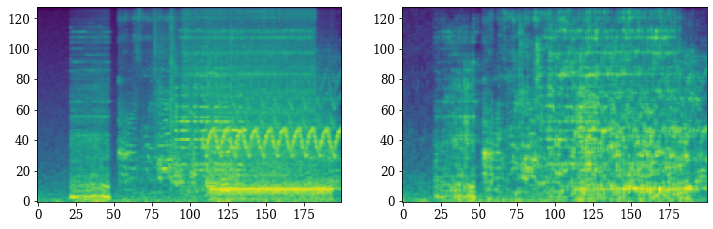

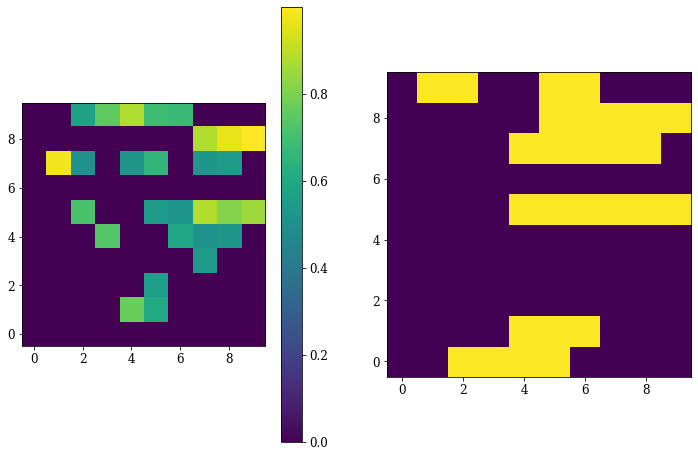

In [21]:
instance = 2

pred = model_container.model.predict(X[instance])[0]

h, mask1, mask2 = model_container.model_encoder.predict(X[instance])
alpha = model_container.model_encoder_mask.predict(X[instance])

H_hat, _ = model_container.model_h_hat().predict(X[instance])
X_hat = model_container.model_decoder.predict([H_hat, mask1, mask2])

print(X_hat.shape, pred.shape)

plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(np.concatenate(X[instance], axis=0).T, origin='lower')
plt.subplot(1,2,2)
plt.imshow(np.concatenate(X_hat, axis=0).T, origin='lower')
plt.show()

plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
#plt.imshow((pred*(pred>0.5)).T, origin='lower')
plt.imshow((pred*(pred>0.5)).T, origin='lower')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(Y[instance].T, origin='lower')
plt.show()

engine_idling


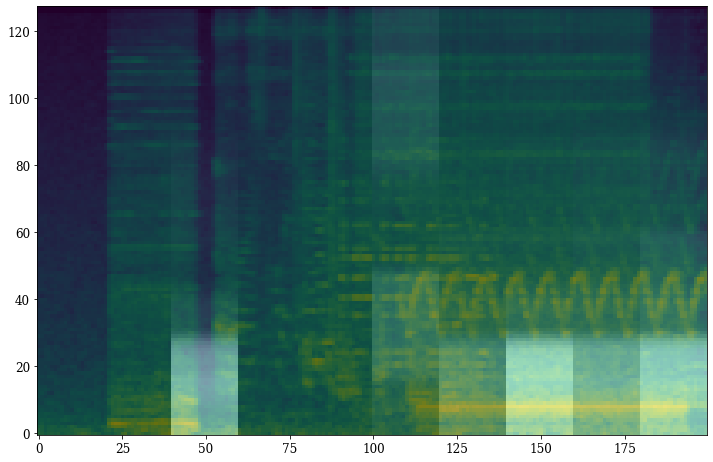

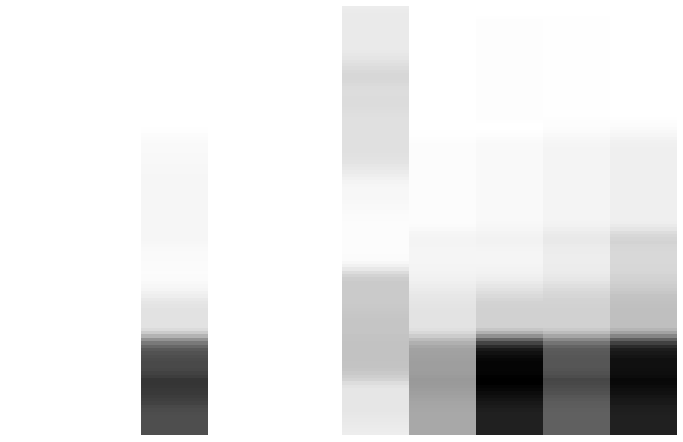

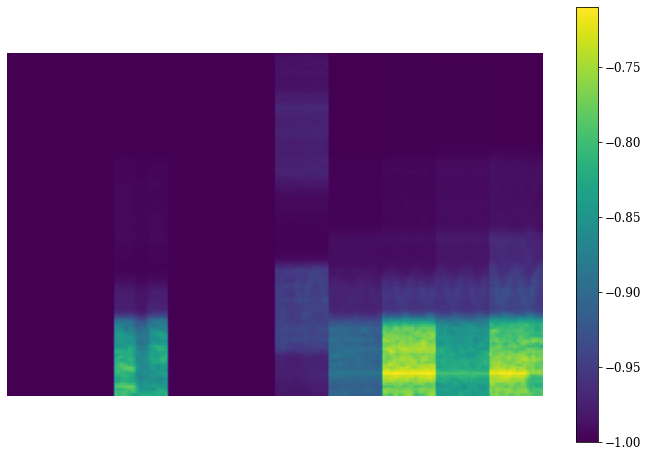

In [22]:
import matplotlib.gridspec as grd

class_ix = 5

print(dataset.label_list[class_ix])

time_hops = np.argwhere(pred[:,class_ix]*(pred[:,class_ix]>0.5)!=0)

logits = pred
mask_logits = np.zeros_like(logits)

mask_logits[time_hops, class_ix] = 1

logits = logits*mask_logits

w = model_container.model.get_layer('dense').get_weights()[0]

grad = logits.dot(w.T)
grad = np.reshape(grad, (10, 32, 15))

alpha2 = np.sum(alpha, axis=1)

alpha_grad = grad*alpha2
alpha_grad = alpha_grad*(alpha_grad>0)


data = np.concatenate(X[instance], axis=0)
saliency = np.zeros_like(data)

for th in time_hops:
    energy = np.sum(alpha_grad[th[0]]**2, axis=0)
    profile = alpha_grad[th[0], :, np.argmax(energy)]
    
    profile_extend = np.interp(np.arange(128), np.arange(32)*4, profile)

    profile_extend = np.convolve(profile_extend, [1/32]*32, mode='same')

    #plt.plot(profile_extend)
    #plt.show()

    saliency[th[0]*20:(th[0] + 1)*20] = profile_extend

plt.figure(figsize=(12,8))

#fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True,figsize=(12,8))

#saliency = np.ma.masked_where((0.0 < saliency) & 
#                             (saliency < 10), saliency)

#saliency = saliency*(saliency>0.1)

plt.imshow(data.T, origin='lower')
plt.imshow(saliency.T, origin='lower', cmap ='gray', alpha=0.5)

#ax = plt.subplot(gs[1])
#ax[1].imshow((pred*(pred>0.5)).T, origin='lower', interpolation='nearest', extent=[0, 200, 0, 10])
plt.show()


plt.figure(figsize=(12,8))

plt.imshow(saliency.T, origin='lower', cmap ='gist_yarg')
plt.axis('off')
plt.show()


plt.figure(figsize=(12,8))
masked_data = 2*((data+1)*saliency/2) - 1
#masked_data[np.abs(masked_data)<0.01] = -1

plt.imshow(masked_data.T, origin='lower')
plt.colorbar()
plt.axis('off')
plt.show()


#for j in range(11):

#    plt.subplot(1,2,1)
#    img = grad[:,:,j]*alpha2[:,:,j]
#    plt.imshow((img*(img>np.mean(img))).T, origin='lower', vmin=0, vmax=np.amax(grad*alpha2))
    #plt.imshow((grad[:,:,j]).T, origin='lower', vmin=np.amin(grad), vmax=np.amax(grad))
    #plt.imshow((alpha2[:,:,j]).T, origin='lower', vmin=np.amin(alpha2), vmax=np.amax(alpha2))
    
#    plt.colorbar()
#    plt.subplot(1,2,2)
#    plt.imshow(X_train[argmin][j].T, origin='lower')
    #plt.title(dataset.label_list[j])
#    plt.show()
    
    

engine_idling
jackhammer
siren


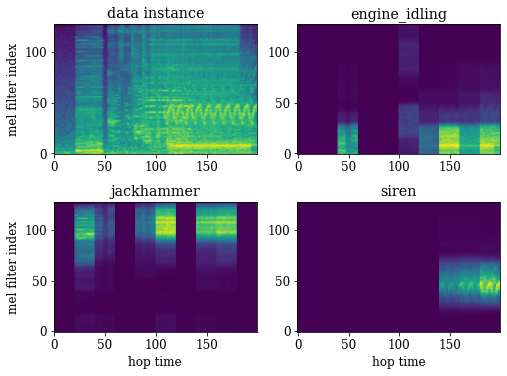

In [23]:
import matplotlib.gridspec as grd



images = []
classes_ix = [5, 7, 8] 

for class_ix in classes_ix:

    print(dataset.label_list[class_ix])

    time_hops = np.argwhere(pred[:,class_ix]*(pred[:,class_ix]>0.5)!=0)

    logits = pred
    mask_logits = np.zeros_like(logits)

    mask_logits[time_hops, class_ix] = 1

    logits = logits*mask_logits

    w = model_container.model.get_layer('dense').get_weights()[0]

    grad = logits.dot(w.T)
    grad = np.reshape(grad, (10, 32, 15))

    alpha2 = np.sum(alpha, axis=1)

    alpha_grad = grad*alpha2
    alpha_grad = alpha_grad*(alpha_grad>0)


    data = np.concatenate(X[instance], axis=0)
    saliency = np.zeros_like(data)

    for th in time_hops:
        energy = np.sum(alpha_grad[th[0]]**2, axis=0)
        profile = alpha_grad[th[0], :, np.argmax(energy)]

        profile_extend = np.interp(np.arange(128), np.arange(32)*4, profile)

        profile_extend = np.convolve(profile_extend, [1/32]*32, mode='same')

        #plt.plot(profile_extend)
        #plt.show()

        saliency[th[0]*20:(th[0] + 1)*20] = profile_extend

    masked_data = 2*((data+1)*saliency/2) - 1
    images.append(np.expand_dims(masked_data, 0))

images = np.concatenate(images, axis=0)
data = np.concatenate(X[instance], axis=0)

plt.rcParams.update({'font.size': 12, 'font.family': 'serif'})

#plt.figure(figsize=(16,4))
plt.figure(figsize=(8,6))
plt.subplot(2,2,1)
plt.imshow(data.T, origin='lower')
plt.title('data instance')
plt.ylabel('mel filter index')
#plt.xlabel('hop time')
plt.subplot(2,2,2)
plt.imshow(images[0].T, origin='lower')
plt.title(dataset.label_list[classes_ix[0]])
#plt.xlabel('hop time')
plt.subplot(2,2,3)
plt.imshow(images[1].T, origin='lower')
plt.title(dataset.label_list[classes_ix[1]])
plt.xlabel('hop time')
plt.ylabel('mel filter index')
plt.subplot(2,2,4)
plt.imshow(images[2].T, origin='lower')
plt.title(dataset.label_list[classes_ix[2]])
plt.xlabel('hop time')
plt.savefig('attention_maps.png', dpi=300, bbox_inches = 'tight',pad_inches = 0)
plt.show()


In [16]:
# Init data generator
data_gen_train = DataGenerator(
    dataset, features, folds=['train'],
    batch_size=params['train']['batch_size'],
    shuffle=False, train=True, scaler=scaler
)
X_train, _ = data_gen_train.get_data()

print(X_train.shape)
_, distances = model_container.model_h_hat().predict(X_train)
print(distances.shape)

(60000, 20, 128)
(60000, 15)


In [24]:
argmin = np.argmin(distances, axis=0)
print(argmin.shape, X_train[argmin].shape)

(15,) (15, 20, 128)


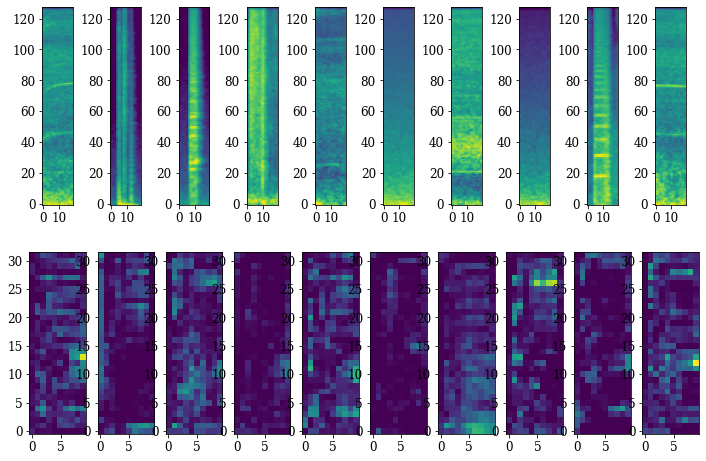

In [25]:
plt.figure(figsize=(12,8))
for k in range(1, 11):
    plt.subplot(2, 10, k)
    plt.imshow(X_train[argmin][k-1].T, origin='lower')
    plt.subplot(2, 10, k+10)
    plt.imshow(alpha2[:,:,k-1].T, origin='lower', vmin=np.amin(alpha2), vmax=np.amax(alpha2))

In [26]:
latent_closest, mask1, mask2 = model_container.model_encoder.predict(X_train[argmin])
prototypes = model_container.model.get_layer('lc').get_weights()[0]

distances_ = np.sum((prototypes - latent_closest)**2, axis=(1,3))
ixs = np.argmin(distances_, axis=1)

#prototypes = np.concatenate([prototypes]*5, axis=1)
#prototypes = np.concatenate([prototypes]*32, axis=2)

prototypes_zeros = np.zeros_like(latent_closest)
mask1_zeros = np.zeros_like(mask1)
mask2_zeros = np.zeros_like(mask2)
x_l = 0
for j, ix in enumerate(ixs):
    prototypes_zeros[j, x_l, ix, :] = prototypes[j,0,0,:]
    start = max(0, ix*2-8)
    end = min(64, ix*2+8) if start !=0 else 16
    start = start if end != 64 else 64 - 16
    mask2_zeros[j, :, start:end] = 1
    start = max(0, ix*4-16)
    end = min(128, ix*4+16) if start !=0 else 32
    start = start if end != 128 else 128 - 32
    mask1_zeros[j, :, start:end] = 1


mask1 = mask1*mask1_zeros
mask2 = mask2*mask2_zeros

print(prototypes.shape)
prototypes_mel = model_container.model_decoder.predict([prototypes_zeros, mask1, mask2])
print(prototypes_mel.shape)
print(mask1.shape, mask2.shape)

(15, 1, 1, 32)
(15, 20, 128)
(15, 20, 128, 32) (15, 10, 64, 32)


[ 1 30  3 31 31  4  8  4 31 31 16 10  8 27 10]
0 20 (20, 20)
0 0
104 128 (20, 24)
1 1
0 28 (20, 28)
0 2
108 128 (20, 20)
1 3
108 128 (20, 20)
0 4
0 32 (20, 32)
1 5
16 48 (20, 32)
0 6
0 32 (20, 32)
1 0
108 128 (20, 20)
0 1
108 128 (20, 20)
1 2
48 80 (20, 32)
0 3
24 56 (20, 32)
1 4
16 48 (20, 32)
0 5
92 124 (20, 32)
1 6
24 56 (20, 32)
0 0


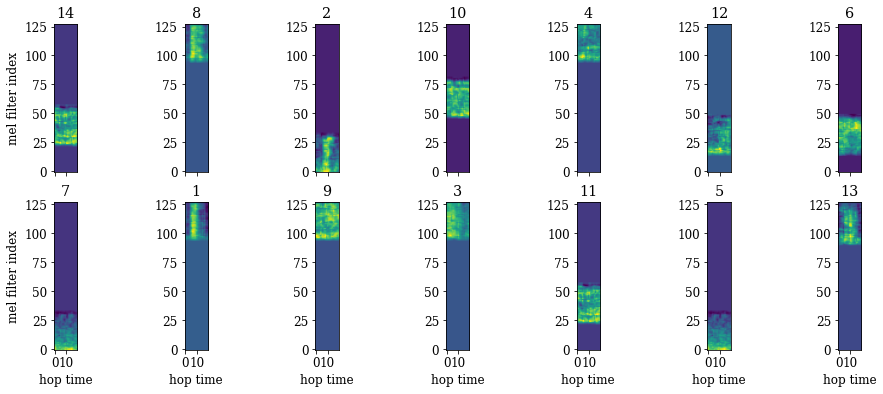

In [27]:
import matplotlib.patches as patches


print(ixs)


fig, axs = plt.subplots(2, 7, figsize=(16,6), sharex=True, subplot_kw={'aspect': 1})
for k in range(15):
    #plt.subplot(1, 15, k)
    start = max(0, ixs[k]*4-16)
    end = min(ixs[k]*4+16, 128)
        
    
    print(start, end, prototypes_mel[k][:, start:end].shape)
    
    local_prototype = prototypes_mel[k][:, start:end]
    if start == 0:
        #local_prototype = np.concatenate((-np.ones((20, 32-end)), local_prototype), axis=1)
        end = 32
    if end == 128:
        start = 128 - 32
        #local_prototype = np.concatenate((local_prototype, -np.ones((20, 32-local_prototype.shape[1])), ), axis=1)

        
    local_prototype = prototypes_mel[k][:, start:end]
    
    #axs[k%2, k%7].imshow(local_prototype.T, origin='lower', extent=[0,20,start,end])
    axs[k%2, k%7].imshow(prototypes_mel[k].T, origin='lower')
    axs[k%2, k%7].set_title(k)
    #
    #axs[k%3, k%5]
    print(k%2, k%7)   
    if k%2 == 1:
        axs[k%2, k%7].set_xlabel('hop time')
    if k%7 == 0:
        axs[k%2, k%7].set_ylabel('mel filter index')
        # Create a Rectangle patch
    #rect = patches.Rectangle((0, ixs[k]*4-14), 20, 32, linewidth=1, edgecolor='r', facecolor='none')

    # Add the patch to the Axes
    #axs[k].add_patch(rect)
plt.savefig('local_prototypes.png', dpi=300, bbox_inches = 'tight',pad_inches = 0)
plt.show()

0 32 (20, 32)
0 0
24 56 (20, 32)
1 1
108 128 (20, 20)
2 0
0 28 (20, 28)
0 1
16 48 (20, 32)
1 0
108 128 (20, 20)
2 1


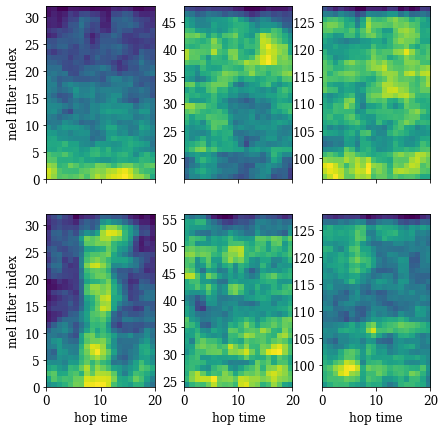

In [28]:
plt.rcParams.update({'font.size': 12, 'font.family': 'serif'})

fig, axs = plt.subplots(2, 3, figsize=(7,7), sharex=True, subplot_kw={'aspect': 1})
for j, k in enumerate([5, 11, 9, 2, 6, 4]):
    #plt.subplot(1, 15, k)
    start = max(0, ixs[k]*4-16)
    end = min(ixs[k]*4+16, 128)
        
    
    print(start, end, prototypes_mel[k][:, start:end].shape)
    
    local_prototype = prototypes_mel[k][:, start:end]
    if start == 0:
        #local_prototype = np.concatenate((-np.ones((20, 32-end)), local_prototype), axis=1)
        end = 32
    if end == 128:
        start = 128 - 32
        #local_prototype = np.concatenate((local_prototype, -np.ones((20, 32-local_prototype.shape[1])), ), axis=1)
    
    local_prototype = prototypes_mel[k][:, start:end]
    
    axs[j%2, j%3].imshow(local_prototype.T, origin='lower', extent=[0,20,start,end])
    #axs[k%3, k%5]
    print(j%3, j%2)   
    if j%2 == 1:
        axs[j%2, j%3].set_xlabel('hop time')
    if j%3 == 0:
        axs[j%2, j%3].set_ylabel('mel filter index')
        # Create a Rectangle patch
    #rect = patches.Rectangle((0, ixs[k]*4-14), 20, 32, linewidth=1, edgecolor='r', facecolor='none')

    # Add the patch to the Axes
    #axs[k].add_patch(rect)
plt.savefig('local_prototypes.png', dpi=300, bbox_inches = 'tight',pad_inches = 0)
plt.show()